In [1]:
%%capture
%matplotlib widget

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [2]:
url = "https://nomad-hzb-ce.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN']
sys.path.insert(1, '../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
sys.path.insert(1, '../../../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
sys.path.insert(1, '../nome-analysis-notebooks-1OmPPM5nSb-Y_g41AdQ66g/hzb-ce-nome-jupyter/CA')
from api_calls import *
from tafel_slope_functions import *

# CA Tafel Slope

This notebook is designed for uploads with multiple `CE_NOME_Chronoamperometry` files.  
It allows you to get the Tafel Slope using all CA files and optionally you can download the calculated data. 

**Copy this notebook to one of your own uploads if you want to design your own plots or analysis steps.**

For interactive general plots take a look at the file `tafel_slope_voila.ipynb`.

In [3]:
upload_names = [
    r'NOMAD API Tutorial',
    #r'NOMAD API Tutorial2',
    #r'NOMAD API Tutorial3',
    ]

data = get_ca_env_upload(url, token, upload_names)

# uncomment the next line to see the data you got
# data

In [4]:
len(data)

1

In [5]:
# make a list to store the data for each data file
time_list = []
current_list = []
current_average_list = []
potential_list = []
sample_id_list = []
environment_ph_list = []
short_name_list = []

avg_points = 40

# iterate over all files
for file in data:
    # navigate inside the data and get the values you are interested in
    # change this depending on your use case
    time = file.get('time')
    current = file.get('current')   # in mA
    potential = file.get('properties').get('step_1_potential')  # in V
    # calculate the average of the last 40 current values (avg_points)
    current_avg = np.mean(current[-avg_points:])
    # append the values to the lists for later usage
    time_list.append(time)
    current_list.append(current)
    potential_list.append(potential)
    current_average_list.append(current_avg)
    
    #sample_id = file.get('samples', [{'name': 'None'}])[0].get('name')
    #sample_id_list.append(sample_id)
    environment_ph = file.get('environment_info', {'ph_value': 0}).get('ph_value')
    environment_ph_list.append(environment_ph)
    
    upload_short_name = file.get('upload_name').replace('NiFe_Electrodeposition_', '')
    short_name_list.append(upload_short_name)
    
overview_table = pd.DataFrame({'potential': potential_list,
                               f'avg last {avg_points} current (mA)': current_average_list,
                               'j (A/cm²)': (np.array(current_average_list)/1000)/6,
                               'environment_ph': environment_ph_list,
                               'upload_name_short': short_name_list,
                              })

#overview_table['log(j (A/cm²))'] = np.log10(overview_table['j (A/cm²)'])
mask = overview_table['j (A/cm²)'] > 0
overview_table.loc[mask, 'log(j (A/cm²))'] = np.log10(overview_table.loc[mask, 'j (A/cm²)'])

overview_table

,potential,avg last 40 current (mA),j (A/cm²),environment_ph,upload_name_short,log(j (A/cm²))
0,-0.0338,0.629749,0.000105,None,NOMAD API Tutorial,-3.978984


In [6]:
# if you want to save the overview data table create a directory 'tafel_slope_data' in your upload and execute this cell
if os.path.exists('tafel_slope_data'):
    for upload_name, upload_df in overview_table.groupby('upload_name_short'):
        file_name = f'tafel_slope_data/overview_table_{upload_name}.csv'
        upload_df.to_csv(file_name, index=False, header=True)


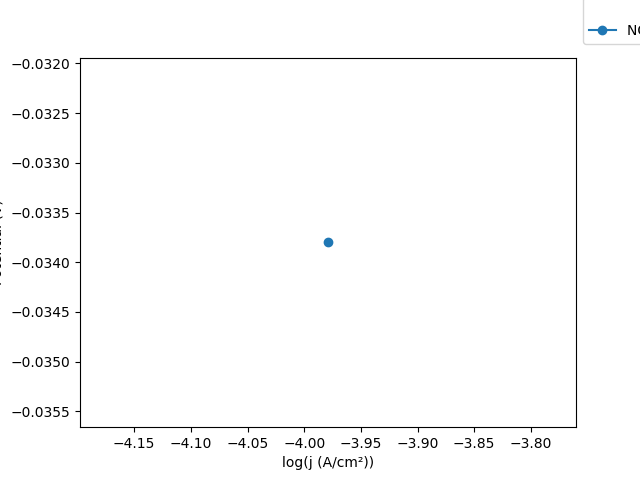

In [7]:
plt.figure()
for upload_name, group in overview_table.groupby('upload_name_short'):
    plt.plot(
        group['log(j (A/cm²))'], 
        group['potential'], 
        marker='o', 
        linestyle='-', 
        label=f'{upload_name}'
    )

plt.xlabel('log(j (A/cm²))')
plt.ylabel('Potential (V)')
plt.legend(title='upload', loc='center left', bbox_to_anchor=(1, 1.1))

# if you want to save the figure create a directory 'tafel_slope_data' in your upload and execute this cell
if os.path.exists('tafel_slope_data'):
    plt.savefig('tafel_slope_data/overview_figure_uploads.png')

plt.show()

/tmp/ipykernel_1715/464233285.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Environment pH')


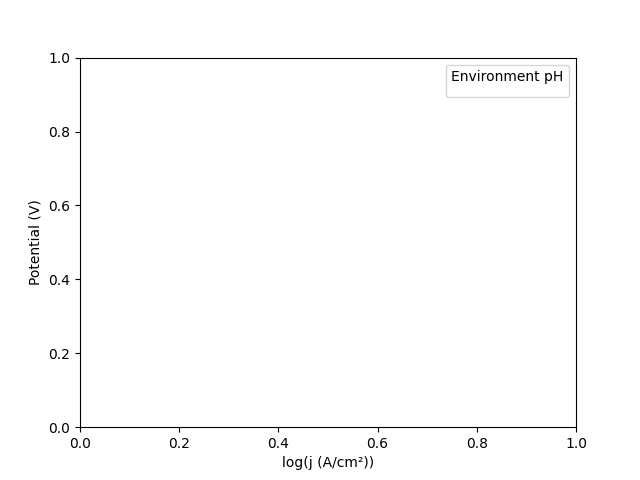

In [8]:
plt.figure()
for env_ph, group in overview_table.groupby('environment_ph'):
    plt.plot(
        group['log(j (A/cm²))'], 
        group['potential'], 
        marker='o', 
        linestyle='-', 
        label=f'{env_ph}'
    )

plt.xlabel('log(j (A/cm²))')
plt.ylabel('Potential (V)')
plt.legend(title='Environment pH')

# if you want to save the figure create a directory 'tafel_slope_data' in your upload and execute this cell
if os.path.exists('tafel_slope_data'):
    plt.savefig('tafel_slope_data/overview_figure.png')

plt.show()

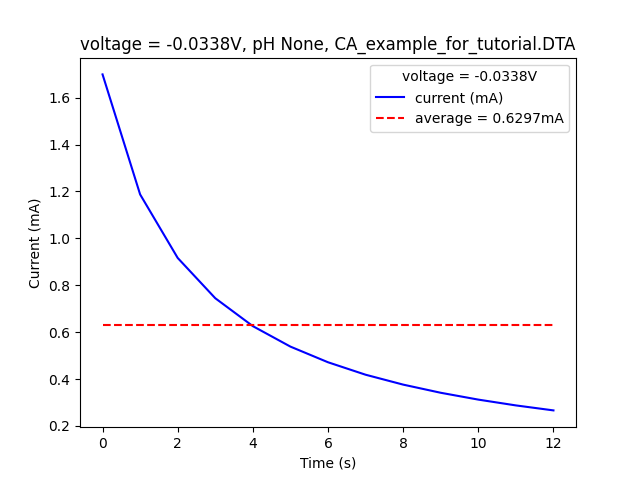

In [9]:
for index in range(len(data)):
    plt.figure()
    plt.plot(time_list[index], current_list[index], color='blue', label='current (mA)')
    avg_points = min(len(time_list[index]), avg_points)
    plt.plot(time_list[index][-avg_points:], [current_average_list[index]]*avg_points, color='red', linestyle='--', label=f'average = {round(current_average_list[index],4)}mA')

    plt.xlabel('Time (s)')
    plt.ylabel('Current (mA)')
    plt.title(f'voltage = {potential_list[index]}V, pH {environment_ph_list[index]}, {data[index].get("data_file")}')

    plt.legend(title=f'voltage = {potential_list[index]}V')

    plt.show()